tgb - 4/10/2020 - Train 4 networks on new aquaplanet preprocessed data:  
1. Standard (RH,T-TNS,LHF) input scaling
2. Same with radiation as additional output
3. Repeat with continuous vertical interpolation layer

# Initialization

In [1]:
import sys
sys.path.insert(1,"/home1/07064/tg863631/anaconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages") #work around for h5py
from cbrain.imports import *
from cbrain.cam_constants import *
from cbrain.utils import *
from cbrain.layers import *
from cbrain.data_generator import DataGenerator
import tensorflow as tf
from tensorflow import math as tfm
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow_probability as tfp
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as imag
import scipy.integrate as sin
# import cartopy.crs as ccrs
import matplotlib.ticker as mticker
# from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import pickle
# from climate_invariant import *
from tensorflow.keras import layers
import datetime
from climate_invariant_utils import *
import yaml

/oasis/scratch/comet/tbeucler/temp_project/CBRAIN-CAM/notebooks/tbeucler_devlog


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15646914538047649355
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 1859565570334349163
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 12092604416
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5284712133385441354
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:05:00.0, compute capability: 3.7"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 16508583576625392350
physical_device_desc: "device: XLA_GPU device"
]


In [3]:
import matplotlib.font_manager
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

['/usr/share/fonts/dejavu/DejaVuSansMono-BoldOblique.ttf',
 '/usr/share/fonts/abattis-cantarell/Cantarell-BoldOblique.otf',
 '/usr/share/fonts/dejavu/DejaVuSans.ttf',
 '/usr/share/fonts/google-noto-emoji/NotoColorEmoji.ttf',
 '/usr/share/fonts/abattis-cantarell/Cantarell-Regular.otf',
 '/usr/share/fonts/dejavu/DejaVuSans-Bold.ttf',
 '/usr/share/fonts/dejavu/DejaVuSansCondensed-Oblique.ttf',
 '/usr/share/fonts/abattis-cantarell/Cantarell-Bold.otf',
 '/usr/share/fonts/dejavu/DejaVuSansMono-Oblique.ttf',
 '/usr/share/fonts/dejavu/DejaVuSansCondensed-Bold.ttf',
 '/usr/share/fonts/dejavu/DejaVuSans-Oblique.ttf',
 '/usr/share/fonts/dejavu/DejaVuSans-BoldOblique.ttf',
 '/usr/share/fonts/dejavu/DejaVuSans-ExtraLight.ttf',
 '/usr/share/fonts/dejavu/DejaVuSansMono.ttf',
 '/usr/share/fonts/dejavu/DejaVuSansCondensed.ttf',
 '/usr/share/fonts/abattis-cantarell/Cantarell-Oblique.otf',
 '/usr/share/fonts/dejavu/DejaVuSansCondensed-BoldOblique.ttf',
 '/usr/share/fonts/dejavu/DejaVuSansMono-Bold.ttf']

# Ankitesh workflow: Exp 1 = (RH,T-TNS,LHFq) input rescaling 

Heavily draws from [https://github.com/ankitesh97/CBRAIN-CAM/blob/flexible_normalization/notebooks/ankitesh_devlog/LHTrans.ipynb]

## Global variables

In [4]:
# Load coordinates (just pick any file from the climate model run)
coor = xr.open_dataset("/oasis/scratch/comet/ankitesh/temp_project/data/sp8fbp_minus4k.cam2.h1.0000-01-01-00000.nc",\
                    decode_times=False)
lat = coor.lat; lon = coor.lon; lev = coor.lev;
coor.close();

In [5]:
TRAINDIR = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/newData/'
path = '/oasis/scratch/comet/tbeucler/temp_project/CBRAIN-CAM/cbrain/'
path_hyam = 'hyam_hybm.pkl'

hf = open(path+path_hyam,'rb')
hyam,hybm = pickle.load(hf)
scale_dict = load_pickle('/oasis/scratch/comet/tbeucler/temp_project/CBRAIN-CAM/nn_config/scale_dicts/009_Wm2_scaling.pkl')

Create data generator class

In [6]:
# class DataGeneratorClimInv(DataGenerator):
    
#     def __init__(self, data_fn, input_vars, output_vars,
#              norm_fn=None, input_transform=None, output_transform=None,
#              batch_size=1024, shuffle=True, xarray=False, var_cut_off=None, 
#                  #normalize_flag=True,
#              rh_trans=True,t2tns_trans=True,
#              lhflx_trans=True,
#              scaling=True,interpolate=True,
#              hyam=None,hybm=None,                 
#              inp_subRH=None,inp_divRH=None,
#              inp_subTNS=None,inp_divTNS=None,
#              lev=None, interm_size=40,
#              lower_lim=6,
#              is_continous=True,Tnot=5):
        
#         self.scaling = scaling
#         self.interpolate = interpolate
#         self.rh_trans = rh_trans
#         self.t2tns_trans = t2tns_trans
#         self.lhflx_trans = lhflx_trans
#         self.inp_shape = 64
#         super().__init__(data_fn, input_vars,output_vars,norm_fn,input_transform,output_transform,
#                         batch_size,shuffle,xarray,var_cut_off) ## call the base data generator
#         self.inp_sub = self.input_transform.sub
#         self.inp_div = self.input_transform.div
#         if rh_trans:
#             self.qv2rhLayer = QV2RHNumpy(self.inp_sub,self.inp_div,inp_subRH,inp_divRH,hyam,hybm)
        
#         if lhflx_trans:
#             self.lhflxLayer = LhflxTransNumpy(self.inp_sub,self.inp_div,hyam,hybm)
            
#         if t2tns_trans:
#             self.t2tnsLayer = T2TmTNSNumpy(self.inp_sub,self.inp_div,inp_subTNS,inp_divTNS,hyam,hybm)
            
#         if scaling:
#             self.scalingLayer = ScalingNumpy(hyam,hybm)
#             self.inp_shape += 1
                    
#         if interpolate:
#             self.interpLayer = InterpolationNumpy(lev,is_continous,Tnot,lower_lim,interm_size)
#             self.inp_shape += interm_size*2 + 4 + 30 ## 4 same as 60-64 and 30 for lev_tilde.size
        
            
        
#     def __getitem__(self, index):
#         # Compute start and end indices for batch
#         start_idx = index * self.batch_size
#         end_idx = start_idx + self.batch_size

#         # Grab batch from data
#         batch = self.data_ds['vars'][start_idx:end_idx]

#         # Split into inputs and outputs
#         X = batch[:, self.input_idxs]
#         Y = batch[:, self.output_idxs]
#         # Normalize
#         X_norm = self.input_transform.transform(X)
#         Y = self.output_transform.transform(Y)
#         X_result = X_norm
        
#         if self.rh_trans:
#             X_result = self.qv2rhLayer.process(X_result) 
            
#         if self.lhflx_trans:
#             X_result = self.lhflxLayer.process(X_result)
#             X_result = X_result[:,:64]
#             X = X[:,:64]
            
#         if self.t2tns_trans:
#             X_result = self.t2tnsLayer.process(X_result)
        
#         if self.scaling:
#             scalings = self.scalingLayer.process(X) 
#             X_result = np.hstack((X_result,scalings))
        
#         if self.interpolate:
#             interpolated = self.interpLayer.process(X,X_result)
#             X_result = np.hstack((X_result,interpolated))
            


#         return X,Y  
    
#     ##transforms the input data into the required format, take the unnormalized dataset
#     def transform(self,X):
#         X_norm = self.input_transform.transform(X)
#         X_result = X_norm
        
#         if self.rh_trans:
#             X_result = self.qv2rhLayer.process(X_result)  
        
#         if self.lhflx_trans:
#             X_result = self.lhflxLayer.process(X_result)

#         if self.t2tns_trans:
#             X_result = self.t2tnsLayer.process(X_result)
        
#         if self.scaling:
#             scalings = self.scalingLayer.process(X) 
#             X_result = np.hstack((X_result,scalings))
        
#         if self.interpolate:
#             interpolated = self.interpLayer.process(X,X_result)
#             X_result = np.hstack((X_result,interpolated))
            

#         return X_result

tgb - 4/13/2020 - Updated class to handle both custom layers and data generator

### Class

In [7]:
class DataGeneratorClimInv(DataGenerator):
    def __init__(self, data_fn, input_vars, output_vars,
             norm_fn=None, input_transform=None, output_transform=None,
             batch_size=1024, shuffle=True, xarray=False, var_cut_off=None, 
             rh_trans=True,t2tns_trans=True,
             lhflx_trans=True,
             scaling=True,interpolate=True,
             hyam=None,hybm=None,                 
             inp_subRH=None,inp_divRH=None,
             inp_subTNS=None,inp_divTNS=None,
             lev=None, interm_size=40,
             lower_lim=6,
             is_continous=True,Tnot=5,mode='train'):
        self.scaling = scaling
        self.interpolate = interpolate
        self.rh_trans = rh_trans
        self.t2tns_trans = t2tns_trans
        self.lhflx_trans = lhflx_trans
        self.inp_shape = 64
        self.mode = mode
        super().__init__(data_fn, input_vars,output_vars,norm_fn,input_transform,output_transform,
                        batch_size,shuffle,xarray,var_cut_off) ## call the base data generator
        self.inp_sub = self.input_transform.sub
        self.inp_div = self.input_transform.div
        if rh_trans:
            self.qv2rhLayer = QV2RHNumpy(self.inp_sub,self.inp_div,inp_subRH,inp_divRH,hyam,hybm)
        if lhflx_trans:
            self.lhflxLayer = LhflxTransNumpy(self.inp_sub,self.inp_div,hyam,hybm)
        if t2tns_trans:
            self.t2tnsLayer = T2TmTNSNumpy(self.inp_sub,self.inp_div,inp_subTNS,inp_divTNS,hyam,hybm)
        if scaling:
            self.scalingLayer = ScalingNumpy(hyam,hybm)
            self.inp_shape += 1
        if interpolate:
            self.interpLayer = InterpolationNumpy(lev,is_continous,Tnot,lower_lim,interm_size)
            self.inp_shape += interm_size*2 + 4 + 30 ## 4 same as 60-64 and 30 for lev_tilde.size
    def __getitem__(self, index):
        # Compute start and end indices for batch
        start_idx = index * self.batch_size
        end_idx = start_idx + self.batch_size
        # Grab batch from data
        batch = self.data_ds['vars'][start_idx:end_idx]
        #print(batch)
        # Split into inputs and outputs
        X = batch[:, self.input_idxs]
        Y = batch[:, self.output_idxs]
        #print(X)
        # Normalize
        X_norm = self.input_transform.transform(X)
        Y = self.output_transform.transform(Y)
        X_result = X_norm
        if self.rh_trans:
            X_result = self.qv2rhLayer.process(X_result) 
        if self.lhflx_trans:
            #print(X_result)
            X_result = self.lhflxLayer.process(X_result)
            X_result = X_result[:,:64]
            X = X[:,:64]
        if self.t2tns_trans:
            X_result = self.t2tnsLayer.process(X_result)
        if self.scaling:
            scalings = self.scalingLayer.process(X) 
            X_result = np.hstack((X_result,scalings))
        if self.interpolate:
            interpolated = self.interpLayer.process(X,X_result)
            X_result = np.hstack((X_result,interpolated))
        if self.mode=='val':
            return xr.DataArray(X_result), xr.DataArray(Y)
        return X_result,Y
    ##transforms the input data into the required format, take the unnormalized dataset
    def transform(self,X):
        X_norm = self.input_transform.transform(X)
        X_result = X_norm
        if self.rh_trans:
            X_result = self.qv2rhLayer.process(X_result)  
        if self.lhflx_trans:
            X_result = self.lhflxLayer.process(X_result)
        if self.t2tns_trans:
            X_result = self.t2tnsLayer.process(X_result)
        if self.scaling:
            scalings = self.scalingLayer.process(X) 
            X_result = np.hstack((X_result,scalings))
        if self.interpolate:
            interpolated = self.interpLayer.process(X,X_result)
            X_result = np.hstack((X_result,interpolated))
        return X_result

## Data generators

### Using RH

In [8]:
scale_dict_RH = load_pickle('/home/ankitesh/CBrain_project/CBRAIN-CAM/nn_config/scale_dicts/009_Wm2_scaling.pkl')
scale_dict_RH['RH'] = 0.01*L_S/G, # Arbitrary 0.1 factor as specific humidity is generally below 2%

in_vars_RH = ['RH','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX', 'TS']
out_vars_RH = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']

TRAINFILE_RH = 'CI_RH_M4K_WTS_NORM_train_shuffle.nc'
NORMFILE_RH = 'CI_RH_M4K_WTS_NORM_norm.nc'
VALIDFILE_RH = 'CI_RH_M4K_WTS_NORM_valid.nc'

In [9]:
train_gen_RH = DataGenerator(
    data_fn = TRAINDIR+TRAINFILE_RH,
    input_vars = in_vars_RH,
    output_vars = out_vars_RH,
    norm_fn = TRAINDIR+NORMFILE_RH,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict_RH,
    batch_size=1024,
    shuffle=True,
    #normalize_flag=True,
)

In [10]:
train_gen_RH[0][0].shape ## 65th is TS

(1024, 65)

In [11]:
train_gen_RH[0][0]

array([[-0.03116154, -0.02579025, -0.05795378, ...,  0.00822388,
        -0.04112007, -0.3510278 ],
       [-0.03114938, -0.02561203, -0.05776227, ..., -0.02999366,
        -0.06616905, -0.37801621],
       [-0.03052856, -0.02457501, -0.04795728, ...,  0.15219427,
         0.07001481, -0.1633932 ],
       ...,
       [-0.02458712, -0.00671786, -0.03637124, ...,  0.01257827,
        -0.05248252, -0.37801621],
       [-0.03113521, -0.02556761, -0.05578798, ..., -0.00397757,
        -0.07242653,  0.05717171],
       [-0.03107435, -0.02489909, -0.05408576, ..., -0.04429404,
        -0.05072512,  0.33383199]])

### Using T-TNS

In [12]:
in_vars = ['QBP','TfromNS','PS', 'SOLIN', 'SHFLX', 'LHFLX', 'TS']
out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']

TRAINFILE_TNS = 'CI_TNS_M4K_WTS_NORM_train_shuffle.nc'
NORMFILE_TNS = 'CI_TNS_M4K_WTS_NORM_norm.nc'
VALIDFILE_TNS = 'CI_TNS_M4K_WTS_NORM_valid.nc'

In [13]:
train_gen_TNS = DataGenerator(
    data_fn = TRAINDIR+TRAINFILE_TNS,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE_TNS,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    #normalize_flag=True
)

In [14]:
train_gen_TNS[0][0]

array([[ 7.8266363e-05,  1.0521860e-04,  8.3636092e-05, ...,
         8.2158856e-03, -4.1136038e-02, -2.3832844e-01],
       [ 1.3011204e-04,  1.3450897e-04,  1.3287229e-04, ...,
        -3.0001657e-02, -6.6185012e-02, -2.6531684e-01],
       [-7.3485826e-05, -6.1155690e-05, -2.2192027e-05, ...,
         1.5218627e-01,  6.9998845e-02, -5.0693844e-02],
       ...,
       [ 2.1072343e-05,  4.2982425e-05,  4.0559629e-05, ...,
         1.2570272e-02, -5.2498486e-02, -2.6531684e-01],
       [ 6.3013263e-06, -1.6509657e-05, -2.3950972e-05, ...,
        -3.9855624e-03, -7.2442487e-02,  1.6987106e-01],
       [-4.2441792e-05, -4.1135834e-05, -4.7525620e-05, ...,
        -4.4302031e-02, -5.0741080e-02,  4.4653136e-01]], dtype=float32)

### Data generator combined

In [15]:
in_vars = ['QBP','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX', 'TS']
out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']

In [16]:
## this won't be used just to show we can use it overall
TRAINFILE = 'CI_SP_M4K_WTS_train_shuffle.nc'
NORMFILE = 'CI_SP_M4K_WTS_NORM_norm.nc'
VALIDFILE = 'CI_SP_M4K_WTS_valid.nc'

train_gen = DataGeneratorClimInv(
    data_fn = TRAINDIR+TRAINFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    #normalize_flag=True,
    lev=lev,
    hyam=hyam,hybm=hybm,
    inp_subRH=train_gen_RH.input_transform.sub, inp_divRH=train_gen_RH.input_transform.div,
    inp_subTNS=train_gen_TNS.input_transform.sub,inp_divTNS=train_gen_TNS.input_transform.div,
    scaling=False,
    interpolate=False
)

valid_gen = DataGeneratorClimInv(
    data_fn = TRAINDIR+VALIDFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    #normalize_flag=True,
    lev=lev,
    hyam=hyam,hybm=hybm,
    inp_subRH=train_gen_RH.input_transform.sub, inp_divRH=train_gen_RH.input_transform.div,
    inp_subTNS=train_gen_TNS.input_transform.sub,inp_divTNS=train_gen_TNS.input_transform.div,
    scaling=False,
    interpolate=False
)

In [17]:
train_gen[0][0]

array([[-3.1150199e-02, -2.5735410e-02, -5.7867717e-02, ...,
        -9.6184701e-02, -8.5013285e-03, -2.6167861e-06],
       [-3.0725701e-02, -2.4526425e-02, -4.3158535e-02, ...,
        -1.1248506e-01,  1.8772926e-02, -7.4758309e-06],
       [-3.0707045e-02, -2.4309644e-02, -4.8080746e-02, ...,
        -2.0640454e-01, -2.7730091e-02, -8.6338832e-06],
       ...,
       [-3.1045359e-02, -2.4920296e-02, -4.6747047e-02, ...,
        -2.3120576e-01, -1.3915333e-02,  8.6682184e-07],
       [-3.1090843e-02, -2.5133165e-02, -5.3446773e-02, ...,
        -2.3120576e-01, -4.2218819e-02, -1.1430574e-06],
       [-3.0709369e-02, -2.4279768e-02, -4.7063876e-02, ...,
        -2.3120576e-01, -6.9839531e-03, -6.5824958e-07]], dtype=float32)

In [18]:
valid_gen[0][0]

array([[-3.11513897e-02, -2.55972967e-02, -5.76855838e-02, ...,
         1.11451395e-01, -1.96151733e-02, -1.00337402e-05],
       [-3.11514307e-02, -2.55967118e-02, -5.76833487e-02, ...,
         1.11603700e-01, -1.98395941e-02, -1.00145280e-05],
       [-3.11514717e-02, -2.55961251e-02, -5.76807670e-02, ...,
         1.11838639e-01, -1.98753774e-02, -9.92992318e-06],
       ...,
       [-3.11518386e-02, -2.56830268e-02, -5.78699596e-02, ...,
        -2.20751569e-01, -2.15642117e-02, -1.04346791e-05],
       [-3.11520100e-02, -2.56797150e-02, -5.79008311e-02, ...,
        -2.21710905e-01, -2.03872118e-02, -1.07214946e-05],
       [-3.11520826e-02, -2.56768707e-02, -5.79310246e-02, ...,
        -2.21848011e-01, -1.85891576e-02, -1.10917099e-05]], dtype=float32)

### Build Model

In [13]:
inp = Input(shape=(64,)) ## input after rh and tns transformation
densout = Dense(128, activation='linear')(inp)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (6):
    densout = Dense(128, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
out = Dense(64, activation='linear')(densout)
model = tf.keras.models.Model(inp, out)

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128)               0     

In [15]:
model.compile(tf.keras.optimizers.Adam(), loss=mse)

In [16]:
path_HDF5 = '/oasis/scratch/comet/tbeucler/temp_project/CBRAIN_models/'
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save_pos = ModelCheckpoint(path_HDF5+'RH_TTNS_SATF.hdf5',save_best_only=True, monitor='val_loss', mode='min')

In [17]:
Nep = 10
# model_pos.load_weights(path_HDF5+'Pos_Scaled_half_Vertical.hdf5')
#model.load_weights(path_HDF5+'RH_TNS_LH.hdf5')
model.fit_generator(train_gen, epochs=Nep, validation_data=valid_gen,\
              callbacks=[earlyStopping, mcp_save_pos])

Epoch 1/10
41376/41376 [==============================] - 3379s 82ms/step - loss: 396.8877 - val_loss: 360.5896
Epoch 2/10
41376/41376 [==============================] - 1335s 32ms/step - loss: 358.4142 - val_loss: 347.4375
Epoch 3/10
41376/41376 [==============================] - 1333s 32ms/step - loss: 351.7821 - val_loss: 344.6531
Epoch 4/10
41376/41376 [==============================] - 1317s 32ms/step - loss: 348.2976 - val_loss: 339.6683
Epoch 5/10
41376/41376 [==============================] - 1311s 32ms/step - loss: 346.1985 - val_loss: 338.8742
Epoch 6/10
41376/41376 [==============================] - 1342s 32ms/step - loss: 344.6709 - val_loss: 339.7956
Epoch 7/10
41376/41376 [==============================] - 1315s 32ms/step - loss: 343.4981 - val_loss: 337.5439
Epoch 8/10
41376/41376 [==============================] - 1327s 32ms/step - loss: 342.4154 - val_loss: 337.2886
Epoch 9/10
41376/41376 [==============================] - 1668s 40ms/step - loss: 341.5560 - val_loss: 3

# Figures for NOAA workshop

## SST generalization plot

TODO where data is, see [https://github.com/tbeucler/CBRAIN-CAM/blob/master/notebooks/tbeucler_devlog/034_AGU2019_Figures.ipynb]

## Four-level input/vertical interpolation hierarchy

### Ankitesh's diagnostic utilities

In [19]:
class ClimateNet:
    def __init__(self,pos_model,neg_model,dict_lay,subQ,divQ,
                rh_trans,t2tns_trans,lhflx_trans,scaling, interpolate):
        self.pos_model = load_model(pos_model,custom_objects=dict_lay)
        self.neg_model = load_model(neg_model,custom_objects=dict_lay)
        self.subQ,self.divQ = np.array(subQ),np.array(divQ)
        in_vars = ['QBP','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
        out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']
        self.pos_data_gen = DataGeneratorClimInv(
                            data_fn = TRAINDIR+'PosCRH_CI_SP_M4K_train_shuffle.nc',
                            input_vars = in_vars,
                            output_vars = out_vars,
                            norm_fn = TRAINDIR+'PosCRH_CI_SP_M4K_NORM_norm.nc',
                            input_transform = ('mean', 'maxrs'),
                            output_transform = scale_dict,
                            batch_size=1024,
                            shuffle=True,
                            #normalize_flag=True,
                            lev=lev,
                            hyam=hyam,hybm=hybm,
                            inp_subRH=train_gen_RH_pos.input_transform.sub, inp_divRH=train_gen_RH_pos.input_transform.div,
                            inp_subTNS=train_gen_TNS_pos.input_transform.sub,inp_divTNS=train_gen_TNS_pos.input_transform.div,
                            is_continous=True,
                            interpolate=interpolate,
                            rh_trans=rh_trans,
                            t2tns_trans=t2tns_trans,
                            
            
                        )

        self.neg_data_gen = DataGeneratorClimInv(
                            data_fn = TRAINDIR+'NegCRH_CI_SP_M4K_train_shuffle.nc',
                            input_vars = in_vars,
                            output_vars = out_vars,
                            norm_fn = TRAINDIR+'NegCRH_CI_SP_M4K_NORM_norm.nc',
                            input_transform = ('mean', 'maxrs'),
                            output_transform = scale_dict,
                            batch_size=1024,
                            shuffle=True,
                            #normalize_flag=True,
                            lev=lev,
                            hyam=hyam,hybm=hybm,
                            inp_subRH=train_gen_RH_neg.input_transform.sub, inp_divRH=train_gen_RH_neg.input_transform.div,
                            inp_subTNS=train_gen_TNS_neg.input_transform.sub,inp_divTNS=train_gen_TNS_neg.input_transform.div,
                            is_continous=True,
                            interpolate=interpolate,
                            scaling=scaling,
                            rh_trans=rh_trans,
                            t2tns_trans=t2tns_trans
                        )

    
    def reorder(self,op_pos,op_neg,mask):
        op = []
        pos_i=0
        neg_i = 0
        for m in mask:
            if m:
                op.append(op_pos[pos_i])
                pos_i += 1
            else:
                op.append(op_neg[neg_i])
                neg_i += 1
        return np.array(op)
                
                
    def predict_on_batch(self,inp):
        #inp = batch x 179
        inp_de = inp[:,:64]*self.divQ + self.subQ
        
        mask = ScalingNumpy(hyam,hybm).crh(inp_de)> 0.8
        pos_inp = inp[mask]
        neg_inp = inp[np.logical_not(mask)]
        ### for positive
        pos_inp = pos_inp*self.divQ + self.subQ
        pos_inp = self.pos_data_gen.transform(pos_inp)
        op_pos = self.pos_model.predict_on_batch(pos_inp)
        neg_inp = neg_inp*self.divQ + self.subQ
        neg_inp = self.neg_data_gen.transform(neg_inp)
        op_neg = self.neg_model.predict_on_batch(neg_inp)
        op = self.reorder(np.array(op_pos),np.array(op_neg),mask)
        return op

In [20]:
path_HDF5 = '/oasis/scratch/comet/ankitesh/temp_project/models/modelsForTom/' # Path to NN weights
config_file = 'CI_SP_M4K_CONFIG.yml' # Configuration file
data_file = ['CI_SP_M4K_valid.nc','CI_SP_P4K_valid.nc'] # Validation/test data sets
NNarray = ['CI01_BF.hdf5','CI01_RH_TNS_LHQsat.hdf5','CI01_RH.hdf5',
           'CI01_RH_TNS_LHQsat_Interp.hdf5','CI01_RH_TNS.hdf5'] # NN to evaluate 
NNname = ['Brute Force','RH TNS QSAT','RH','RH TNS QSAT I','RH TNS'] # Name of NNs for plotting
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer,
            'QV2RH':QV2RH,'T2TmTNS':T2TmTNS,'eliq':eliq,'eice':eice,'esat':esat,'qv':qv,'RH':RH,
           'reverseInterpLayer':reverseInterpLayer,'ScaleOp':ScaleOp}

In [21]:
# def get_data_gen(config_fn, data_fn, normalize_flag=True,nlat=64, nlon=128, nlev=30, ntime=48):

#     repo_dir = os.getcwd().split('CBRAIN-CAM')[0] + 'CBRAIN-CAM/'
#     with open(config_fn, 'r') as f:
#         config = yaml.load(f)
#     in_vars = ['QBP','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX', 'TS']
#     out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']
#     TRAINFILE = 'CI_SP_M4K_WTS_train_shuffle.nc'
#     NORMFILE = 'CI_SP_M4K_WTS_NORM_norm.nc'
#     VALIDFILE = 'CI_SP_M4K_WTS_valid.nc'
#     out_scale_dict = load_pickle(config['output_dict'])
#     valid_gen = DataGeneratorClimInv(
#     data_fn = TRAINDIR+VALIDFILE,
#     input_vars = in_vars,
#     output_vars = out_vars,
#     norm_fn = TRAINDIR+NORMFILE,
#     input_transform = ('mean', 'maxrs'),
#     output_transform = scale_dict,
#     batch_size=nlat*nlon,
#     shuffle=True,
#     #normalize_flag=True,
#     lev=lev,
#     hyam=hyam,hybm=hybm,
#     inp_subRH=train_gen_RH.input_transform.sub, inp_divRH=train_gen_RH.input_transform.div,
#     inp_subTNS=train_gen_TNS.input_transform.sub,inp_divTNS=train_gen_TNS.input_transform.div,
#     scaling=False,
#     interpolate=False
# )
#     return valid_gen

tgb - 4/13/2020 - Update from Ankitesh

In [22]:
def get_data_gen(config_fn, data_fn, nlat=64, nlon=128, nlev=30, ntime=48, interpolate=False):
    repo_dir = os.getcwd().split('CBRAIN-CAM')[0] + 'CBRAIN-CAM/'
    with open(config_fn, 'r') as f:
        config = yaml.load(f)
    in_vars = ['QBP','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
    out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']
    TRAINFILE = 'CI_SP_M4K_WTS_train_shuffle.nc'
    NORMFILE = 'CI_SP_M4K_WTS_NORM_norm.nc'
    VALIDFILE = 'CI_SP_M4K_WTS_valid.nc'
    out_scale_dict = load_pickle(config['output_dict'])
    valid_gen = DataGeneratorClimInv(
    data_fn = TRAINDIR+VALIDFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=nlat*nlon,
    shuffle=True,
    #normalize_flag=True,
    lev=lev,
    hyam=hyam,hybm=hybm,
    inp_subRH=train_gen_RH.input_transform.sub, inp_divRH=train_gen_RH.input_transform.div,
    inp_subTNS=train_gen_TNS.input_transform.sub,inp_divTNS=train_gen_TNS.input_transform.div,
    scaling=False,
    interpolate=interpolate,
    mode='val'
)
#     print(valid_gen)
#     print(valid_gen[0][0])
    return valid_gen

In [23]:
# Indices of different variables
PHQ_idx = slice(0,30)
TPHYSTND_idx = slice(30,60)

### Create model diagnostics object

In [24]:
# NN = {}; md = {};

# for i,NNs in enumerate(NNarray):
#     print('NN name is ',NNs)
#     path = path_HDF5+NNs
#     NN[NNs] = load_model(path,custom_objects=dict_lay)
#     md[NNs] = {}
#     for j,data in enumerate(data_file):
#         print('data name is ',data)
#         ##only         
#         md[NNs][data[6:-3]] = ModelDiagnostics(NN[NNs],
#                                                 '/home/ankitesh/CBrain_project/PrepData/'+config_file,
#                                                 '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'+data)
#         if 'LH' in NNs:
#              md[NNs][data[6:-3]].valid_gen = get_data_gen('/home/ankitesh/CBrain_project/PrepData/'+config_file,
#                                                 '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'+data)

NN = {}; md = {};
for i,NNs in enumerate(NNarray):
    print('NN name is ',NNs)
    path = path_HDF5+NNs
    NN[NNs] = load_model(path,custom_objects=dict_lay)
    md[NNs] = {}
    for j,data in enumerate(data_file):
        print('data name is ',data)
        ##only         
        md[NNs][data[6:-3]] = ModelDiagnostics(NN[NNs],
                                                '/home/ankitesh/CBrain_project/PrepData/'+config_file,
                                                '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'+data)
        if 'LH' in NNs:
             md[NNs][data[6:-3]].valid_gen = get_data_gen('/home/ankitesh/CBrain_project/PrepData/'+config_file,
                                                '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'+data)
        if 'Interp' in NNs:
             md[NNs][data[6:-3]].valid_gen = get_data_gen('/home/ankitesh/CBrain_project/PrepData/'+config_file,
                                                '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'+data, interpolate=True)

NN name is  CI01_BF.hdf5
data name is  CI_SP_M4K_valid.nc


/oasis/scratch/comet/tbeucler/temp_project/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


data name is  CI_SP_P4K_valid.nc


/oasis/scratch/comet/tbeucler/temp_project/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  CI01_RH_TNS_LHQsat.hdf5
data name is  CI_SP_M4K_valid.nc
data name is  CI_SP_P4K_valid.nc
NN name is  CI01_RH.hdf5


/oasis/scratch/comet/tbeucler/temp_project/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/tbeucler/pkg/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:4: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  after removing the cwd from sys.path.
/oasis/scratch/comet/tbeucler/temp_project/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/tbeucler/pkg/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launc

data name is  CI_SP_M4K_valid.nc
data name is  CI_SP_P4K_valid.nc
NN name is  CI01_RH_TNS_LHQsat_Interp.hdf5


/oasis/scratch/comet/tbeucler/temp_project/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/oasis/scratch/comet/tbeucler/temp_project/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


data name is  CI_SP_M4K_valid.nc
data name is  CI_SP_P4K_valid.nc


/oasis/scratch/comet/tbeucler/temp_project/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/tbeucler/pkg/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:4: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  after removing the cwd from sys.path.
/home/tbeucler/pkg/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:4: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  after removing the cwd from sys.path.
/oasis/scratch/comet/tbeucler/temp_project/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain

NN name is  CI01_RH_TNS.hdf5
data name is  CI_SP_M4K_valid.nc
data name is  CI_SP_P4K_valid.nc


/oasis/scratch/comet/tbeucler/temp_project/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/oasis/scratch/comet/tbeucler/temp_project/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


### Accumulate predictions over time in diagnostics object

In [31]:
lat_ind = np.arange(26,40)
# lat_ind = np.arange(57,64)

# e.g. slices of (0,7), (14,20) and (57,64)?
iinis = [500,1000,1500]
# iini = 414 # Initial time to sample
# iend = iini+47 # One day later
diagno = {} # Diagnostics structure
diagno['truth'] = {} # Diagnostics structure for the truth
for i,NNs in enumerate(NNarray):
    print('i=',i,'& NNs=',NNs,'         ')
    diagno[NNs] = {} # Diagnostics structure for each NN
    for j,data in enumerate(data_file):
        diagno[NNs][data[6:-3]]={}
        if i==0: diagno['truth'][data[6:-3]]={}
        for iini in iinis:
            
            print('j=',j,'& iini=',iini,'& data=',data,'         ',end='\r'),
            
            iend = iini+47
            diagno[NNs][data[6:-3]][iini] = {} # Diagnostics structure for each data file
            if i==0: diagno['truth'][data[6:-3]][iini] = {}
            for itime in tqdm(np.arange(iini,iend)):
                # Get input, prediction and truth from NN
                inp, p, truth = md[NNs][data[6:-3]].get_inp_pred_truth(itime)  # [lat, lon, var, lev]
                p = np.array(p)
                # Get convective heating and moistening for each NN
                if itime==iini:
                    if i==0:
                        diagno['truth'][data[6:-3]][iini]['PHQ'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,PHQ_idx])[lat_ind,:,:,np.newaxis]
                        diagno['truth'][data[6:-3]][iini]['TPHYSTND'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]

                    diagno[NNs][data[6:-3]][iini]['PHQ'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,PHQ_idx])[lat_ind,:,:,np.newaxis]
                    diagno[NNs][data[6:-3]][iini]['TPHYSTND'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]
                else:
                    for istr,field in enumerate(['PHQ','TPHYSTND']):
                        if field=='PHQ': ind_field = PHQ_idx
                        elif field=='TPHYSTND': ind_field = TPHYSTND_idx
                        diagno[NNs][data[6:-3]][iini][field] = np.concatenate((diagno[NNs][data[6:-3]][iini][field],
                                                             md[NNs][data[6:-3]].\
                                                             reshape_ngeo(p[:,ind_field])[lat_ind,:,:,np.newaxis]),
                                                            axis=3)
                        if i==0:
                            diagno['truth'][data[6:-3]][iini][field] = np.concatenate((diagno['truth'][data[6:-3]][iini][field],
                                                                     md[NNs][data[6:-3]].\
                                                                     reshape_ngeo(truth[:,ind_field])[lat_ind,:,:,np.newaxis]),
                                                                    axis=3)


i= 0 & NNs= CI01_BF.hdf5          


/home/tbeucler/pkg/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



i= 1 & NNs= CI01_RH_TNS_LHQsat.hdf5          



i= 2 & NNs= CI01_RH.hdf5          



i= 3 & NNs= CI01_RH_TNS_LHQsat_Interp.hdf5          



i= 4 & NNs= CI01_RH_TNS.hdf5          


In [27]:
fz = 20
lw = 4

plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

Test

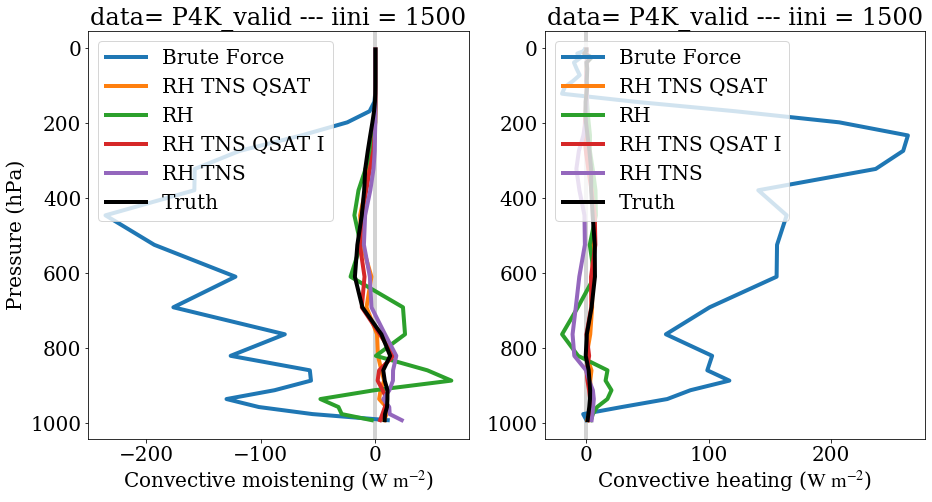

In [34]:
data = 'P4K_valid'
plt.figure(figsize=(15,7.5))
iini = iinis[2]
plt.subplot(1,2,1)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['PHQ'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['PHQ'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()
plt.title('data= '+data+' '+ '--- iini = '+str(iini))


plt.subplot(1,2,2)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective heating ($\mathrm{W\ m^{-2}}$)')
plt.title('data= '+data+' '+ '--- iini = '+str(iini))
plt.gca().invert_yaxis()

### Hierarchy figures

Truth M4

In [41]:
fz = 40
lw = 8

plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

In [45]:
NNarray

['CI01_BF.hdf5',
 'CI01_RH_TNS_LHQsat.hdf5',
 'CI01_RH.hdf5',
 'CI01_RH_TNS_LHQsat_Interp.hdf5',
 'CI01_RH_TNS.hdf5']

In [46]:
NNname

['Brute Force', 'RH TNS QSAT', 'RH', 'RH TNS QSAT I', 'RH TNS']

In [68]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

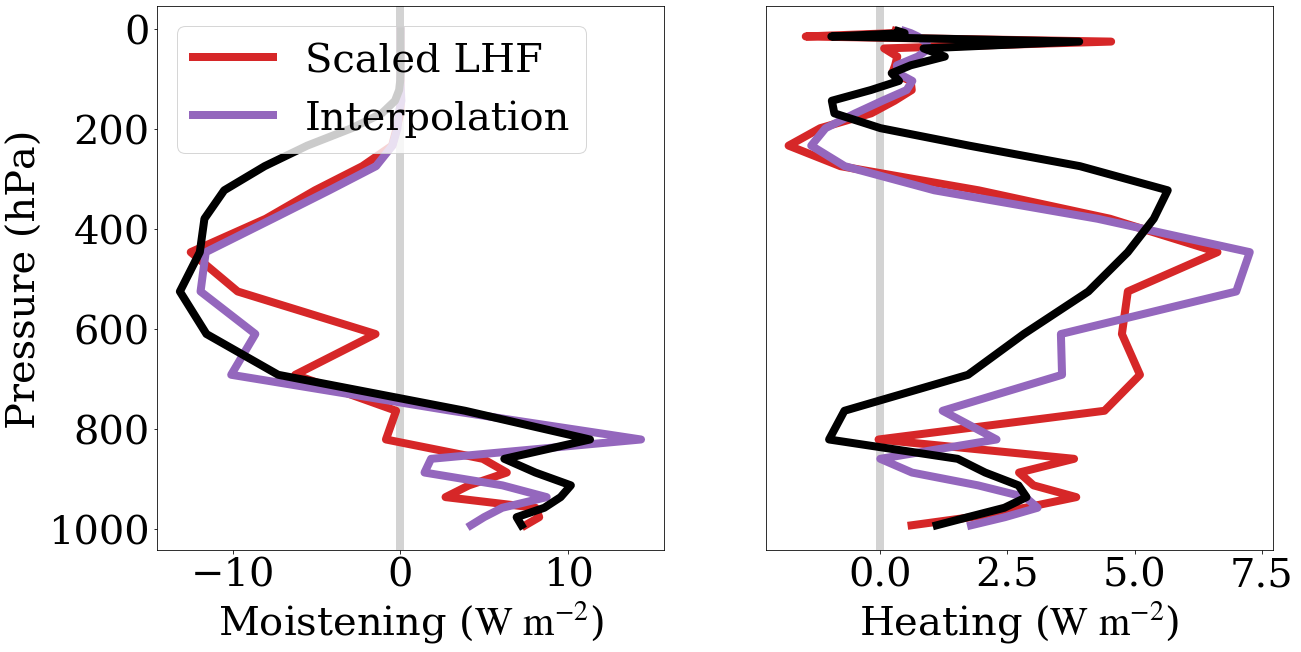

In [76]:
NNa = ['CI01_RH_TNS_LHQsat.hdf5','CI01_RH_TNS_LHQsat_Interp.hdf5']
NNn = ['Scaled LHF','Interpolation']
COL = [colors[3],colors[4]]

data = 'P4K_valid'
plt.figure(figsize=(20,10))
iini = iinis[1]
plt.subplot(1,2,1)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNa):
    plt.plot(np.mean(diagno[NNs][data][iini]['PHQ'],axis=(0,1,3)),lev,label=NNn[iNN],color=COL[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['PHQ'],axis=(0,1,3)),lev,color='k')
plt.legend(loc="upper left")
plt.xlabel('Moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()

plt.subplot(1,2,2)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNa):
    plt.plot(np.mean(diagno[NNs][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label=NNn[iNN],color=COL[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.xlabel('Heating ($\mathrm{W\ m^{-2}}$)')
plt.gca().get_yaxis().set_ticks([])
plt.gca().invert_yaxis()